# CarND-Term1 Project 4: Advance Lane Lines Detection (by Atif)

Finding (advanced) Lane Lines for driving on curved roads. 

##### Import all libraries used in the model

In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy import misc

### Read in the input images from video clip

Base image of size  (720, 1280, 3)


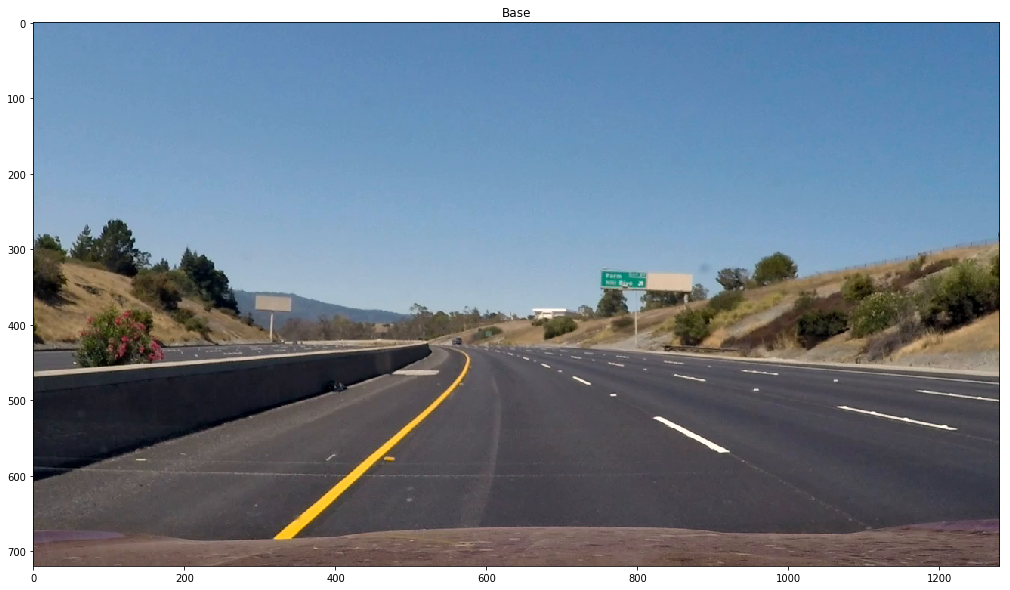

In [2]:
def show_save(img, title, path, size=20, i=1, dim=(1,1)):
    print(title+" image of size ",img.shape)
    fig=plt.figure(figsize=(size, size/2))
    fig.add_subplot(dim[0], dim[1], i).set_title(title)
    plt.imshow(img, 'gray')
    plt.show()
    misc.imsave(path, img)
    #return i+1

def show_existing(fig, i, img, title, path=None, cmap='gray'):
    a = fig.add_subplot(3, 2, i)
    plt.imshow(img, cmap)
    a.set_title(title)
    if path is not None:
        misc.imsave(path, img)
    return i + 1


# using 'project_video', ignoring 'challenge_video', 'harder_challenge_video'
video_in = VideoFileClip('project_video'+'.mp4') #.subclip(30,51)

base = video_in.get_frame(51)
show_save(base,'Base','sample/original.jpg')

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
class CamerCalib: 
    def __init__(self):
        try:
            self.objpoints = np.load('data/objpoints.npy')
            self.imgpoints = np.load('data/imgpoints.npy')
            self.shape = tuple(np.load('data/shape.npy'))
        except:
            self.objpoints = None
            self.imgpoints = None
            self.shape = None

        if self.objpoints is None or self.imgpoints is None or self.shape is None:
            self.find_corners()

        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints,
                                                                               self.shape,
                                                                               None, None)

    def find_corners(self):
        images = glob.glob('camera_cal/calibration*.jpg')
        base_objp = np.zeros((6 * 9, 3), np.float32)
        base_objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
        self.objpoints = []
        self.imgpoints = []
        self.shape = None

        for imname in images:
            img = cv2.imread(imname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if self.shape is None:
                self.shape = gray.shape[::-1]

            print('Finding chessboard corners on {}'.format(imname))
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

            if ret:
                self.objpoints.append(base_objp)
                self.imgpoints.append(corners)

        np.save('data/objpoints', self.objpoints)
        np.save('data/imgpoints', self.imgpoints)
        np.save('data/shape', self.shape)


calib = CamerCalib()
print ('Camera matrix for calibration is \n', calib.mtx)
print ('\nDistortion coefficients ', calib.dist)

plt.imshow(img)
plt.show()

Camera matrix for calibration is 
 [[  1.15778680e+03   0.00000000e+00   6.67098956e+02]
 [  0.00000000e+00   1.15283173e+03   3.86115962e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion coefficients  [[-0.24689204 -0.02370688 -0.0010991   0.00035018 -0.00265908]]


### Apply a distortion correction to raw images.

Undistorted image of size  (720, 1280, 3)


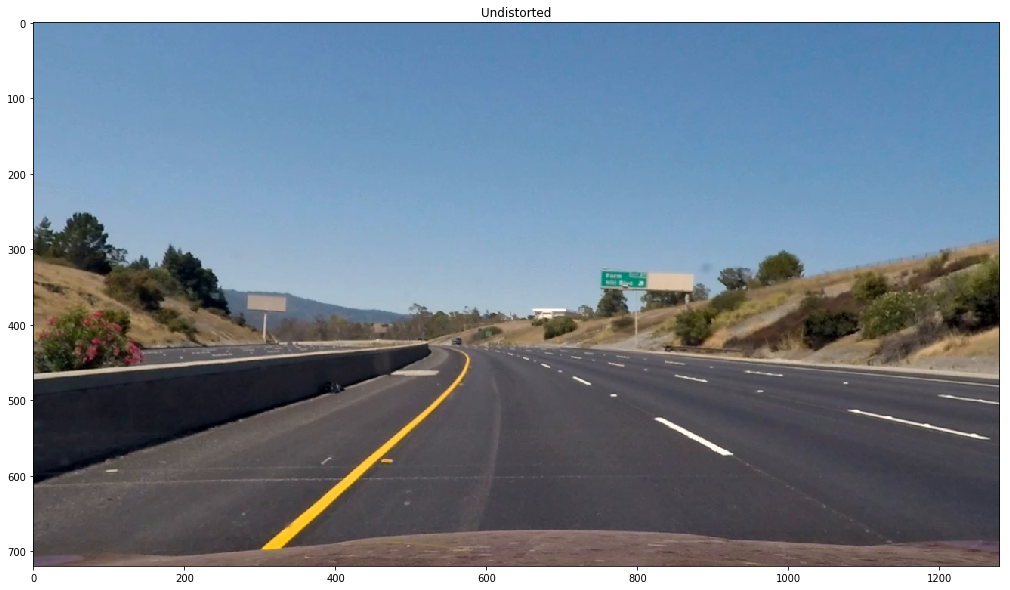

In [4]:
undistorted = cv2.undistort(base, calib.mtx, calib.dist, None, calib.mtx)
show_save(undistorted, 'Undistorted', 'sample/undistorted.jpg')

### Use color transforms, gradients, etc., to create a thresholded binary image.

Thresholded image of size  (720, 1280)


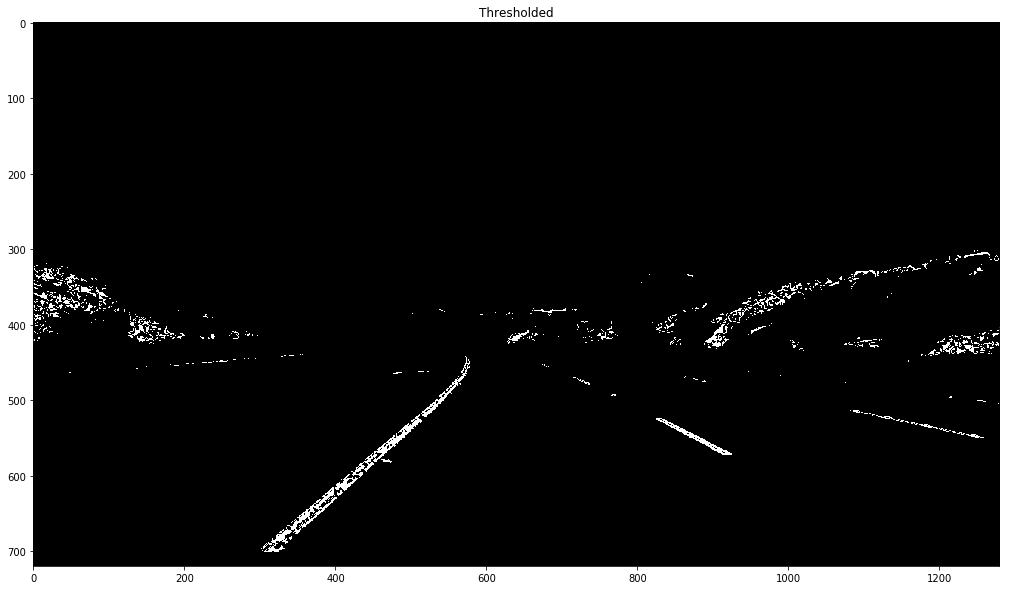

In [5]:
class Thresholder:
    def __init__(self):
        self.sobel_kernel = 15

        self.thresh_dir_min = 0.7
        self.thresh_dir_max = 1.2

        self.thresh_mag_min = 50
        self.thresh_mag_max = 255

    def dir_thresh(self, sobelx, sobely):
        scaled_sobel = np.arctan2(np.abs(sobely), np.abs(sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= self.thresh_dir_min) & (scaled_sobel <= self.thresh_dir_max)] = 1

        return sxbinary

    def mag_thresh(self, sobelx, sobely):
        gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
        scale_factor = np.max(gradmag) / 255
        gradmag = (gradmag / scale_factor).astype(np.uint8)
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= self.thresh_mag_min) & (gradmag <= self.thresh_mag_max)] = 1

        return binary_output

    def color_thresh(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        yellow_min = np.array([15, 100, 120], np.uint8)
        yellow_max = np.array([80, 255, 255], np.uint8)
        yellow_mask = cv2.inRange(img, yellow_min, yellow_max)

        white_min = np.array([0, 0, 200], np.uint8)
        white_max = np.array([255, 30, 255], np.uint8)
        white_mask = cv2.inRange(img, white_min, white_max)

        binary_output = np.zeros_like(img[:, :, 0])
        binary_output[((yellow_mask != 0) | (white_mask != 0))] = 1

        filtered = img
        filtered[((yellow_mask == 0) & (white_mask == 0))] = 0

        return binary_output

    def threshold(self, img):
        sobelx = cv2.Sobel(img[:, :, 2], cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(img[:, :, 2], cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)

        direc = self.dir_thresh(sobelx, sobely)
        mag = self.mag_thresh(sobelx, sobely)
        color = self.color_thresh(img)

        combined = np.zeros_like(direc)
        combined[((color == 1) & ((mag == 1) | (direc == 1)))] = 1

        return combined


thresholder = Thresholder()
img = thresholder.threshold(undistorted)
show_save(img,'Thresholded','sample/thresholded.jpg')

### Apply a perspective transform to rectify binary image ("birds-eye view").

Uses utility function to warp the image to perform Perspective transform to get bird's eye-view, and 
unwarp to get position back onto the original image. 

Warped image of size  (720, 1280)


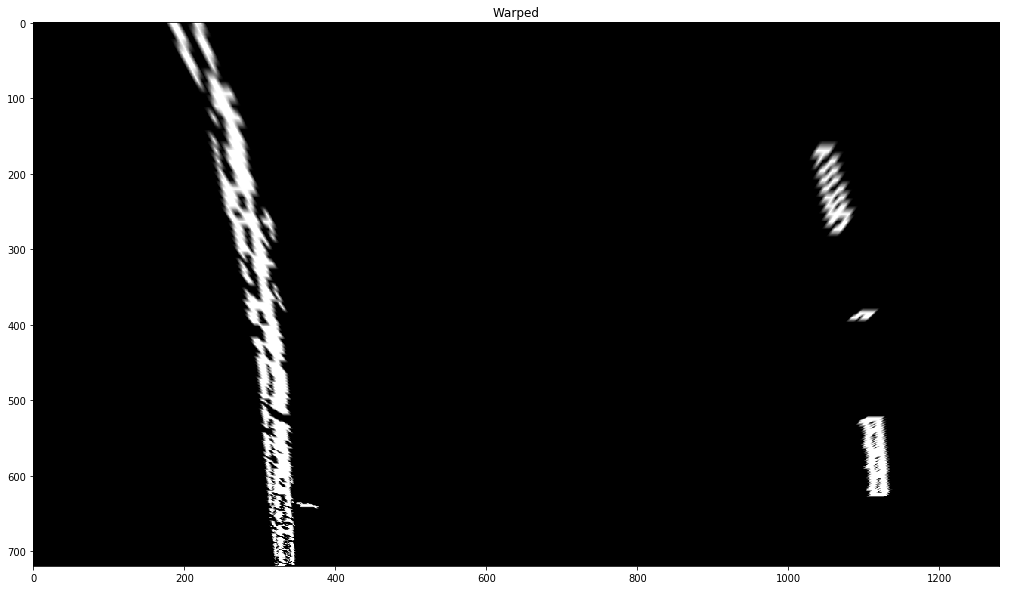

In [6]:
class Warper:
    def __init__(self):
        # A,B,C,D corners of region in perspective view as seen
        src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],
        ])

        # A,B,C,D corners of region in bird's eye view
        dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],
        ])

        # Matrices to change from perspective to bird's view, & vice versa
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)

    # tranform the image from perspective view to bird's eye view
    def warp(self, img):
        return cv2.warpPerspective(
            img,
            self.M,
            (img.shape[1], img.shape[0]),
            flags=cv2.INTER_LINEAR
        )

    # tranform the image from bird's eye view to perspective view
    def unwarp(self, img):
        return cv2.warpPersective(
            img,
            self.Minv,
            (img.shape[1], img.shape[0]),
            flags=cv2.INTER_LINEAR
        )


warper = Warper()
img = warper.warp(img)
show_save(img, 'Warped', 'sample/warped.jpg')

### Detect lane pixels and fit to find the lane boundary.

In [7]:
class Polyfitter:
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.leftx = None
        self.rightx = None

    def polyfit(self, img):
        # if self.left_fit is None:
        return self.polyfit_sliding(img)

        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = (
        (nonzerox > (self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] - margin)) & (
        nonzerox < (self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = (
        (nonzerox > (self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] - margin)) & (
        nonzerox < (self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] + margin)))

        self.leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        self.rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        self.left_fit = np.polyfit(lefty, self.leftx, 2)
        self.right_fit = np.polyfit(righty, self.rightx, 2)

        return self.left_fit, self.right_fit

    def polyfit_sliding(self, img):
        histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
        out_img = np.dstack((img, img, img)) * 255
        midpoint = np.int(histogram.shape[0] / 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9
        window_height = np.int(img.shape[0] / nwindows)
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            win_y_low = img.shape[0] - (window + 1) * window_height
            win_y_high = img.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
                nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
                nonzerox < win_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        self.leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        self.rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        self.left_fit = np.polyfit(lefty, self.leftx, 2)
        self.right_fit = np.polyfit(righty, self.rightx, 2)

        return self.left_fit, self.right_fit


polyfitter = Polyfitter()
left_fit, right_fit = polyfitter.polyfit(img)
print('left  lane line is at x-coords', polyfitter.leftx , '\n and is described by the equation ',  left_fit)
print('right lane line is at x-coords', polyfitter.rightx, '\n and is described by the equation ', right_fit)

left  lane line is at x-coords [313 314 315 ..., 257 258 259] 
 and is described by the equation  [ -2.71017261e-04   3.63907183e-01   2.06666347e+02]
right lane line is at x-coords [1098 1099 1100 ..., 1063 1064 1065] 
 and is described by the equation  [ -1.80110237e-04   3.05034623e-01   1.00006745e+03]


### Determine the curvature of the lane and vehicle position with respect to center.

In [8]:
    def measure_curvature(left_fit, right_fit, img):
        ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
        quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
        leftx = np.array([200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                          for y in ploty])
        rightx = np.array([900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                           for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        y_eval = np.max(ploty)

        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        right_curverad = (
                             (1 + (
                                 2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                                     1]) ** 2) ** 1.5) / np.absolute(
            2 * right_fit_cr[0])

        ratio = left_curverad / right_curverad
        if ratio < 0.66 or ratio > 1.5:
            print('Warning: shitty ratio {}'.format(ratio))

        lane_leftx = left_fit[0] * (img.shape[0] - 1) ** 2 + left_fit[1] * (img.shape[0] - 1) + left_fit[2]
        lane_rightx = right_fit[0] * (img.shape[0] - 1) ** 2 + right_fit[1] * (img.shape[0] - 1) + right_fit[2]

        car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix

        return (left_curverad + right_curverad) / 2, car_pos.round(2)


lane_curve, car_pos = measure_curvature(left_fit, right_fit, img)

lane_curve_text = "Lane curve: {}m".format(lane_curve.round())
print(lane_curve_text)
car_pos_text = 'Car is ' + '{}m {} of center'.format(abs(car_pos), 'right' if (car_pos>0) else 'left')
print(car_pos_text)

Lane curve: 542.0m
Car is 0.46m left of center


### Warp the detected lane boundaries back onto the original image.


Final image of size  (720, 1280, 3)


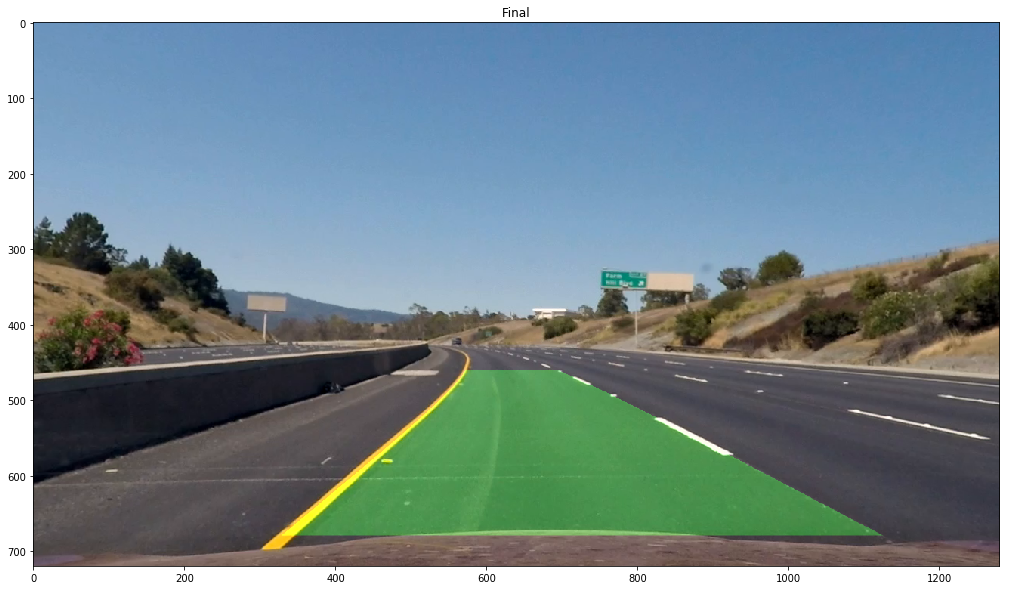

In [9]:
class Polydrawer:
    def draw(self, img, left_fit, right_fit, Minv):
        color_warp = np.zeros_like(img).astype(np.uint8)

        fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
        left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
        right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
        pts = np.hstack((pts_left, pts_right))
        pts = np.array(pts, dtype=np.int32)

        cv2.fillPoly(color_warp, pts, (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        return result


polydrawer = Polydrawer()
img = polydrawer.draw(undistorted, left_fit, right_fit, warper.Minv)
show_save(img, 'Final', 'sample/final.jpg')

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Final image of size  (720, 1280, 3)


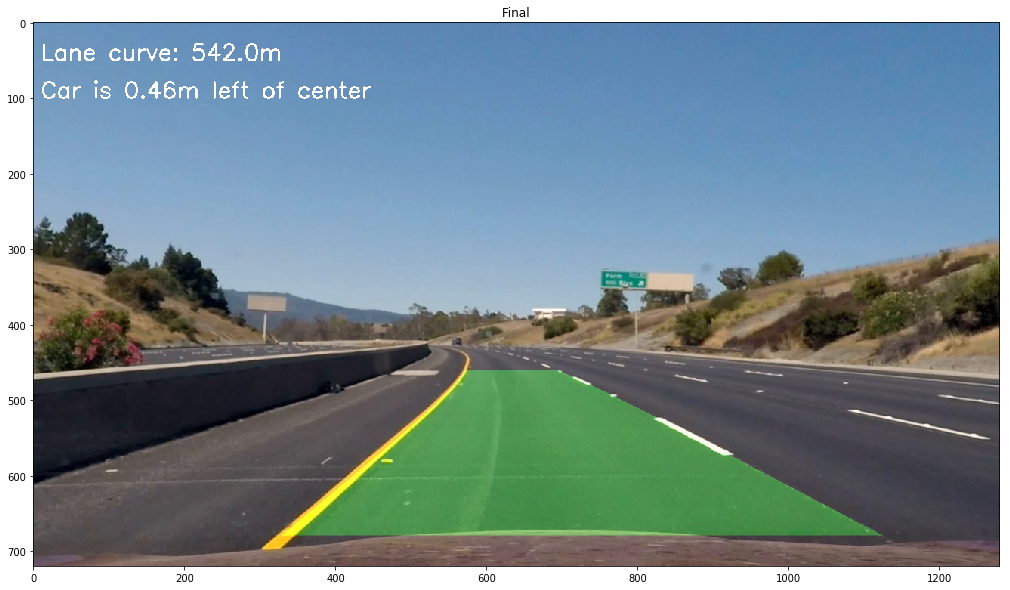

In [10]:
cv2.putText(img, lane_curve_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255), thickness=2)
cv2.putText(img, car_pos_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255), thickness=2)
show_save(img, 'Final', 'sample/final.jpg')

### Combine the routine into a single pipeline
Create a function to process an image through the entire pipeline above.  

Lane curve: 562.0m Car is 0.2m left of center


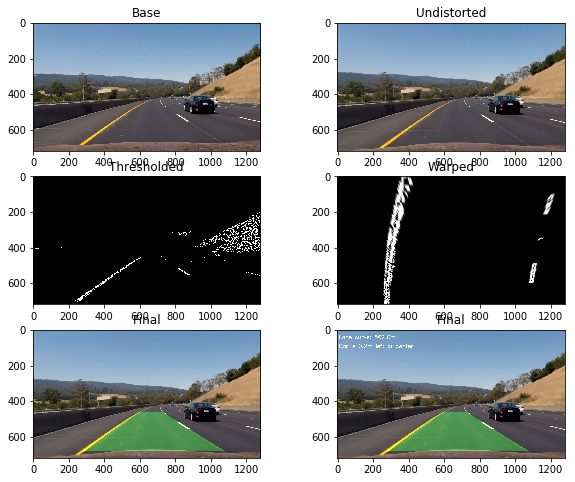

In [11]:
def process_image(base, record=False):
    fig = plt.figure(figsize=(10, 8))
    i = 1
    if record:
        i = show_existing(fig, i, base,'Base','sample/original.jpg')

    #undistorted = undistorter.undistort(base)
    undistorted = cv2.undistort(base, calib.mtx, calib.dist, None, calib.mtx)
    if record:
        i = show_existing(fig, i, undistorted, 'Undistorted', 'sample/undistorted.jpg')

    img = thresholder.threshold(undistorted)
    if record:
        i = show_existing(fig, i, img, 'Thresholded', 'sample/thresholded.jpg')

    img = warper.warp(img)
    if record:
        i = show_existing(fig, i, img, 'Warped', 'sample/warped.jpg')

    left_fit, right_fit = polyfitter.polyfit(img)
    img = polydrawer.draw(undistorted, left_fit, right_fit, warper.Minv)
    if record:
        i = show_existing(fig, i, img, 'Final', 'sample/final.jpg')

    lane_curve, car_pos = measure_curvature(left_fit, right_fit, img)
    lane_curve_text = "Lane curve: {}m".format(lane_curve.round())
    car_pos_text = 'Car is ' + '{}m {} of center'.format(abs(car_pos), 'right' if (car_pos>0) else 'left')
    if record:
        print (lane_curve_text, car_pos_text)

    cv2.putText(img, lane_curve_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255), thickness=2)
    cv2.putText(img, car_pos_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255), thickness=2)
    if record:
        show_existing(fig, i, img, 'Final')
    
    if record:
        #plt.imshow(img)
        #plt.get_current_fig_manager().frame.Maximize(True)
        plt.show()

    return img


base2 = video_in.get_frame(34)
augmented_image = process_image(base2, True)

### Call the routine on entire video clip 
Create the pipeline on all frames of the video. 

In [12]:
video_out = video_in.fl_image(process_image)  # NOTE: this function expects color images!!
video_out.write_videofile('project_video'+'_augmented.mp4', audio=False)

[MoviePy] >>>> Building video project_video_done_2.mp4
[MoviePy] Writing video project_video_done_2.mp4


 39%|███████████████████████████████▏                                               | 497/1261 [02:26<03:43,  3.42it/s]

 43%|██████████████████████████████████▏                                            | 546/1261 [02:40<03:33,  3.35it/s]

 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:32<02:47,  3.24it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [9:20:27<00:00,  3.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_done_2.mp4 

